- In this notebook we'll review the implementation of bidirectional networks on Yelp reviews
- In particular we will use our predictions to calculate two key metrics:
    - __Likelihood to recommend__ and 
    The __Net Promoter Score__
- The likelihood to recommend (LTR) for review $i$ is given by the mapping:
$$
LTR_i = \begin{cases}
1 & \star\star\star\star\star\\
0 & \star\star\star\star\\
-1 & <=\star\star\star
\end{cases}
$$
- The NPS for a given restaurant $j$ is given by the equation:

$$
NPS_j = \frac{\sum_{i=1}^n LTR_{i,j}}{n_j}
$$
where $n_j$ is the total number of reviews for 


- The dataset is available at https://www.yelp.com/dataset/download (~7.4Gbs uncompressed)
    - You will need to sign up to download it
    - Note that you can also download photos (~10.5Gbs)
    
- Here's the approach:
    - Read in the data
        - Note there are several files
        - The files are in json format
    - Munge the data
        - We'll need to pull out the attributes that are most relevant to us
        - Note: you can calculate it for a particular city I suggest: Montréal
    - EDA:
        - Check number of reviews
        - Visualize the star distribution
    - Threshold the star value and map it to LTR
    - Build a bidirectional RNN
        - Here we include some variants 
- Note that here we make the general assumption that:
    - Reviews are invariant to time, region, cuisine type, food price and quality

In [2]:
# --- Importing the libraries ---
import os
import pandas as pd
import numpy as np

# - Plotting -
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)

# - DL Libs -
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Bidirectional, SimpleRNN
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.models import Model

In [2]:
# Setting up the path directories
cwd_path = os.getcwd()
path_to_data = os.path.join(cwd_path,'data_yelp_text')
review_data = os.path.join(path_to_data,'yelp_academic_dataset_review.json')
buisness_data = os.path.join(path_to_data,'yelp_academic_dataset_business.json')

In [3]:
# We will use need buisness info to join the reviews
reviews = pd.read_json(review_data, lines=True)
businesses = pd.read_json(buisness_data, lines=True)

In [4]:
# ---- How many businesses and reviews ----
print("""
----- In the dataset there are -----
        {r} reviews
        {b} businesses""".format(r = reviews.shape[0], 
                                 b = businesses.shape[0]))


----- In the dataset there are -----
        5996996 reviews
        188593 businesses


In [5]:
# ---- Pulling out relevant columns ----
cols_of_interst = ['business_id', 'text','stars']
n_samples = 50000
reviews_small = reviews.sample(n_samples,random_state=1)[cols_of_interst]
print('There are {} reviews'.format(reviews_small.shape[0]))

There are 50000 reviews


In [6]:
# ---- Optional: Filtering columns based on location ----
restaurants_of_interest = businesses.loc[businesses.city == "Montréal"]
restaurants_of_interest_ids = restaurants_of_interest.business_id

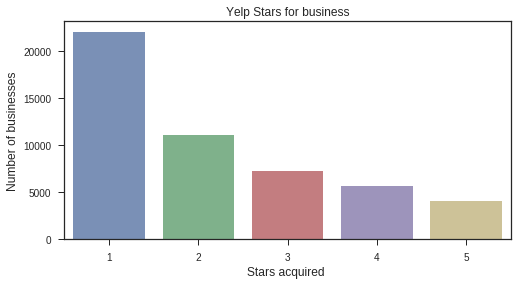

In [7]:
# --- Plotting number of stars ---
# Looks like we have mainly negative reviews
x=reviews_small.stars.value_counts()
y=x.sort_index()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(y.index, x.values, alpha=0.8)
plt.title("Yelp Stars for business")
plt.ylabel('Number of businesses', fontsize=12)
plt.xlabel('Stars acquired ', fontsize=12);
# Note:
# It would also be good to plot the average sentence size since it
# informs how many words we should use in each sentence

In [8]:
# --- Setting up the LTR ---
LTR_apply = lambda x: 1 if x == 5 else ( 0 if x == 4 else -1)
reviews_small["labels"]= reviews.stars.apply(LTR_apply)
reviews_small.head()

# --- Loading text and labels ----
texts = reviews_small["text"].values
labels = reviews_small["labels"].values

In [9]:
# --- Tokenizing texts ----
MAX_NUM_WORDS = 5000 
MAX_SEQUENCE_LENGTH = 100 

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [10]:
# --  Sample sequence ---
# We have 50000 samples with varying lengths (but capped at a length of 100)
print('Sample sequence: ' + ' '.join(str(e) for e in sequences[0]))
#labels

Sample sequence: 3 26 202 382 2 8 6 289 831 1 85 3889 115 3 21 145 23 1 28 6 4679 17 23 1 906 123 14 433 4680 2 1 42 6 2767 1 11 1314 6 4 503 2837 124 1901 5 1295 1154 7 292 7 1 2239 317 3 69 5 12 2853 20 15 151 2 1 91 6 61 79 5 2095 121 280 2928 4 439 14 4 2468 2084 11 8 2 1030 108 254 3073 10 75 3 6 2175 988 18 3 387 4150 13 8 6 1 176 545 210 3 21 145 23


In [11]:
to_categorical(np.asarray(labels), num_classes = 3) # <----- need to change to categorical

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [12]:
# --- Tokenizing the words ---
word_index = tokenizer.word_index
print('Found {w} unique tokens in the texts.'.format(w=len(word_index)))

# --- Padding sequences ---
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# --- Setting up categoires (one-hot-encoded) ---
labeled_categories = to_categorical(labels, num_classes=3)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labeled_categories.shape)

Found 63661 unique tokens in the texts.
Shape of data tensor: (50000, 100)
Shape of label tensor: (50000, 3)


In [13]:
# --- Splitting out data intro training/test ----
VALIDATION_SPLIT=0.2

# Note: since this is a random sample we don't really
# need a shuffle but will but is included for completeness
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labeled_categories = labeled_categories[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

# --- Train/Validation Set ---
x_train = data[:-nb_validation_samples]
y_train = labeled_categories[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labeled_categories[-nb_validation_samples:]

In [14]:
# --- Setting up embedding layer ----
# Here we use pretrained GloVe Embeddings in 100d space
# Note that you can access the embeddings at:
# (1) https://nlp.stanford.edu/projects/glove/ or
# (2) https://github.com/stanfordnlp/GloVe

# - Setting the path directory -
path_to_glove ='fill in'
glove_dir = os.path.join(path_to_glove, 'glove_6B')

# Dictionary where we store the word:vector_embedding map
embeddings_index = {}

# Setting up embedding array
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    # - First entry is the word -
    word = values[0]
    # - The remaining vectors are strings that need to be converted to floats-
    coefs = np.asarray(values[1:], dtype='float32')
    # Embeddings is a dictionary of words:word_vector_embeddings
    embeddings_index[word] = coefs
f.close()
print('Found {} word vectors.'.format(len(embeddings_index)))

Found 400000 word vectors.


In [15]:
# -- Embedding of 'happy' ---
embeddings_index['happy']

array([-0.090436 ,  0.19636  ,  0.29474  , -0.47706  , -0.80436  ,
        0.3078   , -0.55205  ,  0.58453  , -0.17056  , -0.84846  ,
        0.19528  ,  0.23671  ,  0.46827  , -0.58977  , -0.12163  ,
       -0.24697  , -0.072944 ,  0.17259  , -0.0485   ,  0.9527   ,
        0.50629  ,  0.58497  , -0.19367  , -0.45459  , -0.031095 ,
        0.51633  , -0.24052  , -0.1007   ,  0.53627  ,  0.024225 ,
       -0.50162  ,  0.73692  ,  0.49468  , -0.34744  ,  0.89337  ,
        0.057439 , -0.19127  ,  0.39333  ,  0.21182  , -0.89837  ,
        0.078704 , -0.16344  ,  0.45261  , -0.41096  , -0.19499  ,
       -0.13489  , -0.016313 , -0.021849 ,  0.17136  , -1.2413   ,
        0.079503 , -0.91144  ,  0.35699  ,  0.36289  , -0.24934  ,
       -2.1196   ,  0.14534  ,  0.52964  ,  0.90134  ,  0.033603 ,
        0.022809 ,  0.70625  , -1.0362   , -0.59809  ,  0.70592  ,
       -0.072793 ,  0.67033  ,  0.52763  , -0.47807  , -0.67374  ,
        0.36632  , -0.38284  , -0.10349  , -0.6402   ,  0.1810

In [16]:
# --- Creating the embedding matrix from our feedback ----
# Embedding dimension
EMBEDDING_DIM = 100 

# Embedding matrix (63661,100)
# Recall word_index is a dictionary mapping between words and numbers
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

# Mapping word embeddings to vals in matrix
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        

In [17]:
# --- Define embedding layer ----
from keras.layers import Embedding

# Note that we freeze the embedding layer
# The embedding functions selects
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [18]:
# --- Rudnning the model ----
# - Here we use the functional API -
inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedded_sequences = embedding_layer(inp)
x = Bidirectional(SimpleRNN(100, 
                             return_sequences=False, 
                             dropout=0.1, 
                             recurrent_dropout=0.1))(x)
x = Dense(3, activation="softmax")(x)

# Setting the model
model = Model(inputs=inp, outputs=x)

# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          6366200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               40200     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 603       
Total params: 6,407,003
Trainable params: 40,803
Non-trainable params: 6,366,200
_________________________________________________________________


In [21]:
history = model.fit(x_train, y_train, 
                    validation_data=(x_val, y_val),
          epochs=20, batch_size=256);

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 7s 180us/step - loss: 0.9017 - acc: 0.5867 - val_loss: 0.8743 - val_acc: 0.6103
Epoch 2/20
40000/40000 [==============================] - 7s 180us/step - loss: 0.8940 - acc: 0.5911 - val_loss: 0.8537 - val_acc: 0.6228
Epoch 3/20
40000/40000 [==============================] - 8s 191us/step - loss: 0.8938 - acc: 0.5910 - val_loss: 0.9970 - val_acc: 0.5389
Epoch 4/20
40000/40000 [==============================] - 7s 180us/step - loss: 0.8938 - acc: 0.5927 - val_loss: 0.8493 - val_acc: 0.6248
Epoch 5/20
40000/40000 [==============================] - 7s 172us/step - loss: 0.8902 - acc: 0.5954 - val_loss: 0.8865 - val_acc: 0.6003
Epoch 6/20
40000/40000 [==============================] - 7s 174us/step - loss: 0.8851 - acc: 0.5976 - val_loss: 0.8678 - val_acc: 0.6128
Epoch 7/20
40000/40000 [==============================] - 7s 176us/step - loss: 0.8874 - acc: 0.5962 - val_loss: 0.8616 - 

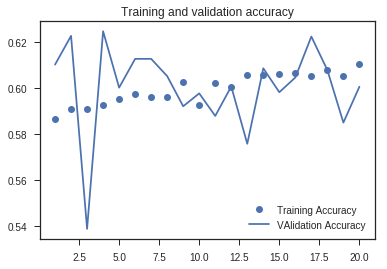

In [22]:
#-- Plotting the results --
import matplotlib.pyplot as plt

# ~ Plotting parameters ~
# Pulling out :
#   - Training: accuracy and loss
#   - validation: accuracy and loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the data 

# Training + Valdiation Accuracy
epochs = range(1,len(acc) + 1)
plt.plot( epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot( epochs, val_acc, 'b', label = 'VAlidation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [27]:
l = labeled_categories.sum(axis=0)
l 

array([11067., 22044., 16889.], dtype=float32)

In [28]:
from pandas_ml import ConfusionMatrix
y_true = y_val.argmax(axis=1)
preds  =  model.predict(x_val)

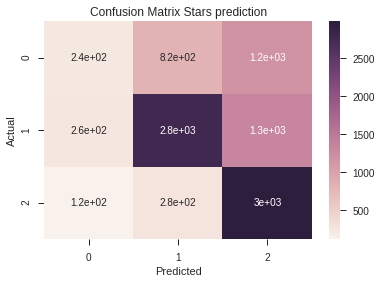

In [29]:
cm = ConfusionMatrix(y_true, preds.argmax(axis=1))
cm.plot(backend='seaborn', normalized=False, annot=True)
plt.title('Confusion Matrix Stars prediction')
plt.figure(figsize=(12, 10))

In [155]:
model.predict([[x_val[1]]])

array([[0.07424366, 0.6016894 , 0.00228724]], dtype=float32)

In [31]:
print(labels[0:5])
labeled_categories[0:5,:]

[ 1 -1  1  1 -1]


array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)